In [ ]:
%matplotlib inline

# Assignment 3

**DUE: Sunday November 6, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = "Anish Pahilajani"
STUDENT_ID = "1726777"


## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [ ]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2022-11-07 02:05:28--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  27.1MB/s    in 0.3s    

2022-11-07 02:05:28 (27.1 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [ ]:
import pandas as pd
import numpy as np
import glob

def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let's take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()
# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]

### a) Understanding the Data (2 points)
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data?
*   Exaplain what the code provided above is trying to achieve.



### Answer:
- There are 4000 entries and there are 25 parameters in the data. The names of the parameters are foundin the "attrs" list on line 13.

- The code creates a pandas dataframe with all the data in txt files present in /content/set-a/* . It concatnates all the parameters together. It also sets all values that are 'NaN' (invalid entries) to the average of that column 

### b) Run Logistic Regression (9 points)


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [ ]:
full_dat_out.describe()

,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,K,Na,FiO2,GCS,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,64.247500,0.561921,169.787227,83.043044,134.017937,87.159565,36.956125,57.351445,118.591225,59.543420,...,4.135057,138.859128,0.549199,11.604248,137605.122000,14.961680,6.678942,13.661675,351.063772,0.138500
std,17.560946,0.496027,14.637111,23.118025,117.228862,14.488338,0.727350,10.920285,16.531284,8.927074,...,0.487365,4.052678,0.104083,3.229533,2923.608886,5.053809,3.950194,12.115969,321.616216,0.345467
min,15.000000,0.000000,1.800000,3.500000,0.000000,42.784314,21.644615,0.000000,0.000000,0.000000,...,2.500000,111.500000,0.276000,3.000000,132539.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,52.750000,0.000000,169.787227,68.201596,74.066176,77.274047,36.614286,50.492284,111.082108,55.860440,...,3.800000,136.500000,0.500000,9.307692,135075.750000,11.000000,4.000000,6.000000,298.000000,0.000000
50%,67.000000,1.000000,169.787227,82.000000,113.852484,86.617585,36.963636,57.351445,118.591225,59.543420,...,4.100000,138.859128,0.549199,12.333333,137592.500000,15.000000,6.678942,10.000000,351.063772,0.000000
75%,78.000000,1.000000,170.200000,93.058712,160.397104,96.465443,37.364603,63.168478,123.502049,62.213890,...,4.400000,141.000000,0.562500,14.750000,140100.250000,18.000000,9.000000,17.000000,351.063772,0.000000
max,90.000000,1.000000,431.800000,300.000000,3082.380952,137.842105,39.748980,107.500000,181.725000,106.666667,...,7.600000,164.533333,1.000000,15.000000,142673.000000,34.000000,22.000000,154.000000,2600.000000,1.000000


Removing outliers and cleaning data

In [ ]:
indexes= full_dat_out[ (full_dat_out['Gender'] != 1) & (full_dat_out['Gender'] != 0 )].index
# dropping values of gender that are not 1 or 0
full_dat_out.drop(indexes, inplace=True)


# remove outliers for height and weight
full_dat_out['HeightZ'] = (full_dat_out['Height']-full_dat_out['Height'].mean())/full_dat_out['Height'].std()
indexes= full_dat_out[ (full_dat_out['HeightZ'] >4) | (full_dat_out['HeightZ'] < -4 )].index
full_dat_out.drop(indexes, inplace=True)
full_dat_out.drop(columns=["HeightZ"], inplace=True)

#explain
full_dat_out['WeightZ'] = (full_dat_out['Weight']-full_dat_out['Weight'].mean())/full_dat_out['Weight'].std()
indexes= full_dat_out[ (full_dat_out['WeightZ'] >3) | (full_dat_out['WeightZ'] < -3 )].index
full_dat_out.drop(indexes, inplace=True)
full_dat_out.drop(columns=["WeightZ"], inplace=True)

# do normalize of Z transform not both
# Normalize HR Do I normalize other coluns when do I normalize? why do we not normalize, height weight?
full_dat_out['HR'] = (full_dat_out['HR']-full_dat_out['HR'].min())/(full_dat_out['HR'].max()-full_dat_out['HR'].min())
full_dat_out['Age'] = (full_dat_out['Age']-full_dat_out['Age'].min())/(full_dat_out['Age'].max()-full_dat_out['Age'].min())

full_dat_out.describe()

,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,K,Na,FiO2,GCS,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
count,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,...,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000
mean,0.658487,0.560814,169.691486,81.873263,133.870587,0.466273,36.953913,57.347271,118.605467,59.520067,...,4.132714,138.857324,0.548967,11.614548,137605.138168,14.962543,6.665580,13.575242,350.903190,0.138168
std,0.234035,0.496351,7.861780,19.984417,117.257485,0.152011,0.721584,10.927440,16.419396,8.872463,...,0.484585,4.051654,0.103807,3.221718,2924.096307,5.049583,3.933010,12.029158,321.261883,0.345120
min,0.000000,0.000000,121.900000,20.386567,0.000000,0.000000,21.644615,0.000000,0.000000,0.000000,...,2.500000,111.500000,0.280000,3.000000,132539.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.506667,0.000000,169.787227,68.100000,74.242857,0.361760,36.614560,50.494403,111.079657,55.833394,...,3.800000,136.500000,0.500000,9.340909,135076.250000,11.000000,4.000000,6.000000,302.500000,0.000000
50%,0.693333,1.000000,169.787227,81.832014,113.837971,0.460272,36.960769,57.351445,118.591225,59.543420,...,4.100000,138.859128,0.549199,12.357143,137596.500000,15.000000,6.678942,10.000000,351.063772,0.000000
75%,0.840000,1.000000,170.200000,92.268500,160.150000,0.564427,37.356250,63.173913,123.479792,62.045381,...,4.400000,141.000000,0.562500,14.750000,140101.500000,18.000000,9.000000,16.000000,351.063772,0.000000
max,1.000000,1.000000,205.700000,152.200000,3082.380952,1.000000,39.748980,107.500000,181.725000,106.666667,...,7.600000,164.533333,1.000000,15.000000,142673.000000,34.000000,22.000000,154.000000,2600.000000,1.000000


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# x = full_dat_out.loc[:,full_dat_out.columns != 'In-hospital_death']
x = full_dat_out[['HR', 'Gender', 'Age', 'Temp', 'Weight', 'Height', 'PaO2', 'PaCO2']]
y = full_dat_out.loc[:, full_dat_out.columns == 'In-hospital_death']
# x = full_dat_out.drop(columns=['Urine', 'NIDiasABP', 'SysABP', 'DiasABP', 'pH', 'Platelets', 'MAP', 'K', 'Na', 'FiO2', 'GCS', 'RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death'])
#y = full_dat_out.iloc[:, 24]
x = x.values
y = y.values
y = y.reshape(x.shape[0],)
display(f"X shape = {x.shape}")
display(f"y shape = {y.shape}")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 140)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=140)
clf = LogisticRegression(max_iter=4000).fit(x_train, y_train) # max_iter=4000

'X shape = (3930, 8)'

'y shape = (3930,)'

### c) ROC Curve (10 points)

Write a function that, for a given threshold (prob. threshold), calculates both the False Positive Rate (proportion of non-deaths identified as deaths by the model) and True Positive Rate (proportion of deaths correctly identified as such by the model) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


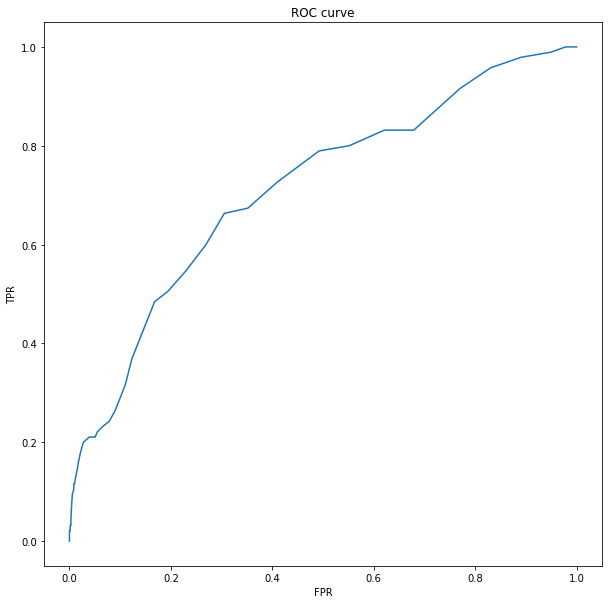

In [ ]:
### YOUR CODE HERE ###
# https://towardsdatascience.com/understanding-the-roc-curve-in-three-visual-steps-795b1399481c#:~:text=To%20plot%20the%20ROC%20curve,That's%20it!
import matplotlib.pyplot as plt

FPR = []
TPR = []
y_val_prob = clf.predict_proba(x_val)[:,1]

def ROC_curve(threshold):
    TP = 0
    FN = 0
    FP = 0
    TN = 0
    for i in range(len(x_val)): # validation data
        if y_val_prob[i] >= threshold:
            Pred = 1
        else:
            Pred = 0
        
        if Pred == 1 and y_val[i] == 1.0: # predecticted death was a death TP
            TP+=1
        elif Pred == 1 and y_val[i] == 0.0: # FP
            FP += 1
        if Pred == 0 and y_val[i] == 0.0: # predecticted alive was not a death TN
            TN +=1
        elif Pred == 0 and y_val[i] == 1.0: # FN
            FN += 1 
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))


for j in np.linspace(0,1,100):
    ROC_curve(j)
plt.figure(figsize=(10,10))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(FPR, TPR)

plt.show()

        



### d) Interpreting the ROC Curve (4 points)

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


### Answer:
The Flase Postive Rate associated with correctly identifying 80% of the patient is around 60%

A high false positive rate is approprite in this setting as a doctor would rather provide medication to somone who might not need it rather than miss somone who might die if they do not get the appropriate medication.


### e) Modelling Doctors' Decision-Making (6 points)

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [ ]:
# part 1:
t = 60/25
prob_fail = np.exp(-pow(t,2)/100) # prob of 1 patient dying
Total_fail_prob = prob_fail*10 # prob of 10 patients dying
#Total_pass_prob = (1-prob_fail)*15 
#print(f"Percentage of patients expected to die: {Total_fail_prob/(Total_fail_prob+Total_pass_prob)}")
print(f"1) Percentage of patients expected to die: {(Total_fail_prob/25)*100}%")

# part 2:
t = 60/25 #(x_val.shape[0]*60)/(x_val.shape[0]*25)
prob_fail = np.exp(-pow(t,2)/100)
count = 0
for i in range(len(x_val)):
    if y_val[i] == 1:
        count+=1
print(f"2) Number of patients expected to die: {prob_fail*count}") 

#part 3:
count_doctorNotlooked = 0
count_looked = 0
count_overTwenty = 0
for i in range(len(y_val_prob)):
    if y_val_prob[i] < 0.2 and y_val[i] == 1:
        count_doctorNotlooked+=1
    if y_val_prob[i] >= 0.2 and y_val[i] == 1:
        count_looked+=1
    if y_val_prob[i] >= 0.2:
        count_overTwenty+=1
t = (x_val.shape[0]*60)/(count_overTwenty*25)
prob_fail = np.exp(-pow(t,2)/100)
print(f"3) Number of patients expected to die: {(prob_fail*count_looked) + count_doctorNotlooked}")

1) Percentage of patients expected to die: 37.76109931671343%
2) Number of patients expected to die: 89.68261087719439
3) Number of patients expected to die: 61.79420437588342


### Answer:
1) if the doctor gave everyone an equal amount of time; the percentage of patients expected to die are 37.76%

2) Out of 786 patients about 90 would die

3) If the doctor uses the model and only looks at patients with more than 0.2 threshold, about 62 patients will die out of 786 patients. 

### f) Modelling Doctors' Decision-Making - Revisited (7 points)


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




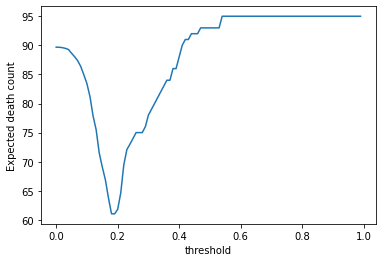

Minimum Expected death:  61.02019357993946


In [ ]:
### YOUR CODE HERE ###
threshold = np.arange(0, 1, 0.01)
y_val_prob = clf.predict_proba(x_val)[:,1]
t = (x_val.shape[0]*60)/(x_val.shape[0]*25)
prob_fail = np.exp(-pow(t,2)/100)
policy = []

for thr in threshold:
    count_doctorNotlooked = 0
    count_looked = 0
    count_overThr = 0
    for i in range(len(y_val_prob)):
        if y_val_prob[i] < thr and y_val[i] == 1:
            count_doctorNotlooked+=1
        if y_val_prob[i] >= thr and y_val[i] == 1:
            count_looked+=1
        if y_val_prob[i] >= thr:
            count_overThr+=1
    if count_overThr == 0:
        policy.append(count_doctorNotlooked)
    else:
        t = (x_val.shape[0]*60)/(count_overThr*25)
        prob_fail = np.exp(-pow(t,2)/100)
        policy.append(((prob_fail*count_looked) + count_doctorNotlooked))

plt.xlabel("threshold")
plt.ylabel("Expected death count")
plt.plot(threshold, policy)
plt.show()
print("Minimum Expected death: ", min(policy))

### Answer:
As we can see in the graph above, the threshold that would best minmize the deaths is 0.2, having about 62 out of 786 would die.

This shows the best threshold value (0.2) that minimizes the amount of untreated patients who would die without treatment and maximise the amount of time that the doctor spends on each of the patients.


### g) Modelling Doctors' Decision-Making - Testing (7 points)

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [ ]:
thr = 0.2
y_test_prob = clf.predict_proba(x_test)[:,1]
t = 60/25
prob_fail = np.exp(-pow(t,2)/100)

real_death_count = 0
for i in y_test:
    if i == 1:
        real_death_count+=1
Expect_prob_fail_real = prob_fail * real_death_count
print("Reviewing each patients file")
print("Number of death: ", Expect_prob_fail_real)
ep = (Expect_prob_fail_real*100)/len(y_test)
print(f"percet = {ep}\n\n")

count_doctorNotlooked = 0
count_looked = 0
count_overThr = 0
for i in range(len(y_test_prob)):
    if y_test_prob[i] < thr and y_test[i] == 1:
        count_doctorNotlooked+=1
    if y_test_prob[i] >= thr and y_test[i] == 1:
        count_looked+=1
    if y_test_prob[i] >= thr:
        count_overThr+=1
t = (x_test.shape[0]*60)/(count_overThr*25)
prob_fail = np.exp(-pow(t,2)/100)
total_prob = ((prob_fail*count_looked) + count_doctorNotlooked)
print("patient using best policy")
print("Number of death: ", total_prob)
tp = (total_prob*100)/len(y_test)
print(f"percet = {tp}\n\n")


print("Difference in lives saved")
print("Number of lives saved if doctor used model: ", Expect_prob_fail_real-total_prob)
#print(f"percent = {((real_death_count*100)/len(y_test) - (total_prob*100)/len(y_test)) / (((real_death_count*100)/len(y_test) + (total_prob*100)/len(y_test) )/2)}%")
#print(((real_death_count*100)/len(y_test) - (total_prob*100)/len(y_test))/ (((real_death_count*100)/len(y_test) + (total_prob*100)/len(y_test) )/2))
print(f"percentage difference: {100*(ep-tp)/((tp+ep)/2)}%")
    

Reviewing each patients file
Number of death:  120.83551781348297
percet = 15.373475548789182


patient using best policy
Number of death:  101.07387194801717
percet = 12.859271240205747


Difference in lives saved
Number of lives saved if doctor used model:  19.761645865465795
percentage difference: 17.810554016398203%


Using the best policy the doctor can save about 20 more lives which is 17.8% improvement.

## Question 2 - Neural Networks
---

We will train a fully connected neural networks to recognize face images of cats and dogs. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
data_dir = 'pets'
image_width = 32
image_height = 32
batch_size = 10

### a) Load the Pets Dataset (2 points)
There are 110 images of size $32\times32$. Run the following code block to import the data. Keep in mind that they will be downloaded from the internet, so it may take a while.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download the data
downloaded = drive.CreateFile({'id':"1NXiYkupBcolg90e6wE_Nm_F9VTFoXIja"})
downloaded.GetContentFile('pets.npy')  
data = np.load("pets.npy",allow_pickle=True)

In [ ]:
# Create X and y
X, y = (data[()]['X'], data[()]['y'])

In [ ]:
# Get class names and create ID
class_names = ['cat', 'dog']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

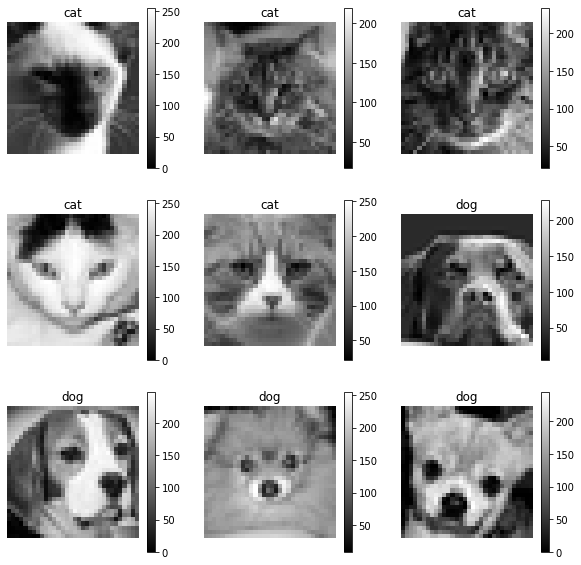

In [ ]:
# Plot some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(X[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

Answer the following questions:

1.) What are the data types for X and y?

2.) What are the shapes of X and y?

3.) What is the minimum and maximum value of X?

In [ ]:
print("Data type of y: ", type(y))
print("Data type of X: ", type(X))

print("\n\nshape of X: ", X.shape)
print("shape of y: ", y.shape)

print("\n\nmin of X: ", X.min())
print("max of X: ", X.max())

Data type of y:  <class 'numpy.ndarray'>
Data type of X:  <class 'numpy.ndarray'>


shape of X:  (110, 32, 32)
shape of y:  (110,)


min of X:  0
max of X:  255


### Answer:
1) Data type of X: 3D numpy.ndarray, Representing greyscale picture of cats and dogs.


data type of y: 1D numpy.ndarray of numbers (0 or 1) represetning classification of X data. (0 = "cat" and 1 = "dog")

2) Shape of X: (110, 32, 32) 110 represents the number of pictures in X and (32, 32) represents the image size. So each picture has 32 pixels width and 32 pixels height.

   Shape of y: numpy array of length 110

3) min value of X = 0
   Max value of X = 255

### b) Data Preprocessing (3 points)
As you can see above, the pixel values are in the [0,255]. This is the normal range for images. Recall from the previous lectures and excercises that we need to normalize our data.

In order to normalize our data to [0,1] we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to [0,1] the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different. Sometimes you want to normalize between [-1,1], for that you would use a slightly different equation.


Normalize the X data using the above equation and save as train_images.

In [ ]:
train_images =  X/255# YOUR CODE HERE

If we show the image agian, you will see the values are all scaled correctly.

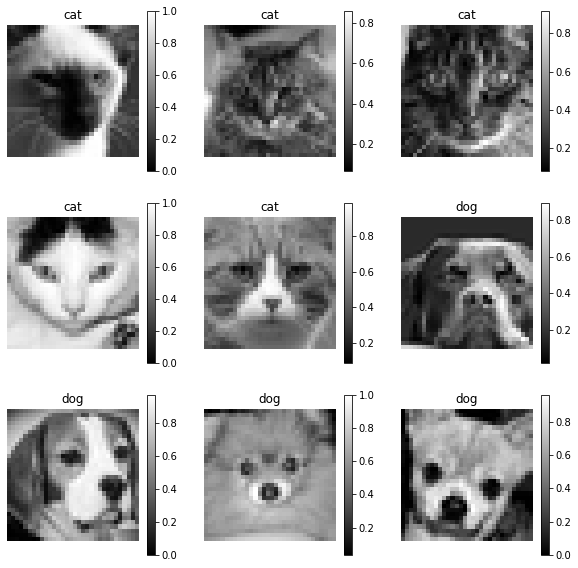

In [ ]:
# Plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

What is the new minimum and maximum value of X?

### Answer:
Min value of X = 0

max value of X = 1

### c) Reshaping the Data (5 points)

Please reshpe training images to be 1024-dim (from $32 \times 32$). 

Hint: look into numpy.reshape().


In [ ]:
print(f'Before reshape, train_images shape: {train_images.shape}')

train_images = np.reshape(train_images, (110, 1024))# YOUR CODE HERE

print(f'Before reshape, train_images shape: {train_images.shape}')


Before reshape, train_images shape: (110, 32, 32)
Before reshape, train_images shape: (110, 1024)


### d) Building a Simple Neural Network (15 points)
In the cell below, build a fully-connected feed-forward neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [ ]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import *

# Build neural network
# YOUR CODE HERE
model = Sequential()
# NOT SURE
model.add(Input(shape=(1024)))
model.add(Dense(units = 25, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

# model.add(Dense(units = 1024, input_dim = 1024, activation = 'relu'))
# model.add(Dense(units = 25, activation = 'relu'))
# model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
# Show a summary of your model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                25625     
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 25,651
Trainable params: 25,651
Non-trainable params: 0
_________________________________________________________________


Declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using the 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [ ]:
# Declare optimizer
optimizer = SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)# YOUR CODE HERE

# Compile model
# YOUR CODE HERE
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Now we will train our model to learn pet faces using train_images and the 'y' labels. Our dataset is small so we will use 10% of the data as test set data. Train your model using the following parameters:

Fit your model using the train_images, 'y' labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

.fit documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [ ]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist = model.fit(train_images, y, epochs = 500, batch_size = 10, validation_split=0.1) # YOUR CODE HERE

Epoch 1/500
10/10 [==============================] - 1s 22ms/step - loss: 0.8778 - accuracy: 0.4444 - val_loss: 0.3600 - val_accuracy: 1.0000
Epoch 2/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5253 - val_loss: 0.5099 - val_accuracy: 0.9091
Epoch 3/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6162 - val_loss: 0.6128 - val_accuracy: 0.7273
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6171 - accuracy: 0.7172 - val_loss: 0.6582 - val_accuracy: 0.6364
Epoch 5/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.7273 - val_loss: 0.6637 - val_accuracy: 0.6364
Epoch 6/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6054 - accuracy: 0.7273 - val_loss: 0.6740 - val_accuracy: 0.5455
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.5998 - accuracy: 0.7374 - val_loss: 0.6930 - val_accuracy: 0.4545
Epoch 8/500


In [ ]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

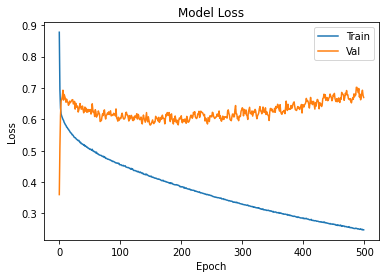

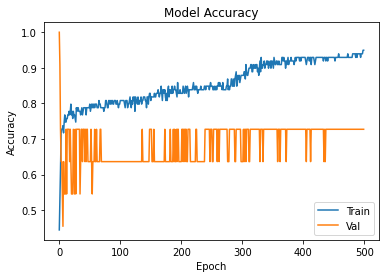

In [ ]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

For the input size, this one hidden layer neural network is probably too small. However, we can see that the model attempts to minimize the overall loss. Summarize your observations on the model's learning curves, model's overall classification accuracy on the validation set, and the least amount of loss on validation set?

In [ ]:
print("max val accuracy", max(hist.history['val_accuracy']))
print("min val loss", min(hist.history['val_loss']))
print("\n\n")
print("final val accuracy", hist.history['val_accuracy'][-1])
print("final val loss", hist.history['val_loss'][-1])
print("\n\n")
print("final train accuracy", hist.history['accuracy'][-1])
print("final train loss", hist.history['loss'][-1])

max val accuracy 1.0
min val loss 0.36001861095428467



final val accuracy 0.7272727489471436
final val loss 0.6696863770484924



final train accuracy 0.9494949579238892
final train loss 0.2476034015417099


### Answer:

The model is overfitting as the accuracy of the training data gradually increases to 0.939 and the Loss gradually reduces to 0.265 by 500eth epoch

However, the loss for validation data can be seen reducing to 0.66 and accuracy going up to 0.81, by 500 epoch. These values are far form the training data, thus indicating the model is overfitting. 

We can get better results if we trained for fewer epochs

the minimum values of validation loss = 0.5570570826530457

The maximum value of validation accuracy = 1.0



### e) Building a Second Neural Network (15 points)
Next, you will build a neural network with one hidden layer that is wider than the previous model's hidden layer. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [ ]:
# Build Neural network
# YOUR CODE HERE
model = Sequential()
model.add(Input(shape=(1024)))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
# model.add(Dense(units = 1024, input_dim = 1024, activation = 'relu'))
# model.add(Dense(units = 100, activation = 'relu'))
# model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
# Show a summary of your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               102500    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


Again, declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [ ]:
# Declare optimizer
optimizer = SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)# YOUR CODE HERE

# Compile model
# YOUR CODE HERE
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [ ]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist = model.fit(train_images, y, epochs = 500, batch_size = 10, validation_split=0.1)# YOUR CODE HERE

Epoch 1/500
10/10 [==============================] - 1s 46ms/step - loss: 0.7224 - accuracy: 0.5253 - val_loss: 0.9407 - val_accuracy: 0.0909
Epoch 2/500
10/10 [==============================] - 0s 12ms/step - loss: 0.7106 - accuracy: 0.5758 - val_loss: 0.9066 - val_accuracy: 0.1818
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 0.7015 - accuracy: 0.5859 - val_loss: 0.8733 - val_accuracy: 0.1818
Epoch 4/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6950 - accuracy: 0.5758 - val_loss: 0.8540 - val_accuracy: 0.1818
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6889 - accuracy: 0.5859 - val_loss: 0.8416 - val_accuracy: 0.1818
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6814 - accuracy: 0.6061 - val_loss: 0.8362 - val_accuracy: 0.1818
Epoch 7/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6781 - accuracy: 0.6061 - val_loss: 0.8274 - val_accuracy: 0.1818
Epoch 8/5

In [ ]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

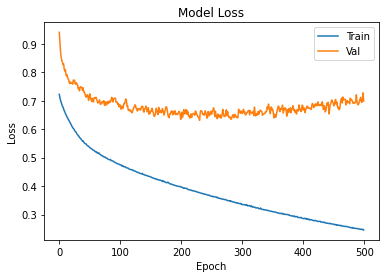

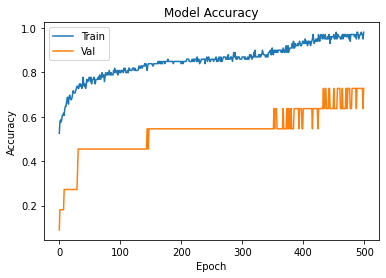

In [ ]:
# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Next, summarize this models results. Consider the following questions when answering. Remember that this model has a higher learning capacity than the previous model. 

1) How did this model compare to previous model? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

In [ ]:
print("max val accuracy", max(hist.history['val_accuracy']))
print("min val loss", min(hist.history['val_loss']))
print("\n\n")
print("final val accuracy", hist.history['val_accuracy'][-1])
print("final val loss", hist.history['val_loss'][-1])
print("\n\n")
print("final train accuracy", hist.history['accuracy'][-1])
print("final train loss", hist.history['loss'][-1])

max val accuracy 0.7272727489471436
min val loss 0.6308503746986389



final val accuracy 0.7272727489471436
final val loss 0.6989229321479797



final train accuracy 0.9797979593276978
final train loss 0.24581745266914368


### Answer:
Model performs about the same as the previos model. It did not outperform the previos model.

The max value of for validation accuracy = 0.7272727489471436

min value of validation loss = 0.6308503746986389

overall validaiton accuracy = 0.7272727489471436

Conclusion: Increasing the number of neurons in the hidden layer did not improve the model



### f) Building a Third Neural Network (15 points)
Lastly, you will build a fully-connected neural network with two hidden layers. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [ ]:
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer

# Build Neural network
# YOUR CODE HERE
model = Sequential()
model.add(Input(shape=(1024)))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 25, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
# model = Sequential()
# model.add(Dense(units = 1024, input_dim = 1024, activation = 'relu'))
# model.add(Dense(units = 100, activation = 'relu'))
# model.add(Dense(units = 25, activation = 'relu'))
# model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
# Show a summary of your model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               102500    
                                                                 
 dense_8 (Dense)             (None, 25)                2525      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 105,051
Trainable params: 105,051
Non-trainable params: 0
_________________________________________________________________


Since this model is bigger than the previous models, we will use a more powerful optimizer. Declare the optimizer as Adam with learning rate of 0.001. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [ ]:
# Declare optimizer
optimizer =  Adam(learning_rate=0.001)# YOUR CODE HERE

# Compile model
# YOUR CODE HERE
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [ ]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y. 
# Train for 500 epochs with a batch size of 10 and validation split of 0.1
hist = model.fit(train_images, y, epochs = 500, batch_size = 10, validation_split=0.1)# YOUR CODE HERE

Epoch 1/500
10/10 [==============================] - 1s 45ms/step - loss: 0.6620 - accuracy: 0.6263 - val_loss: 0.9612 - val_accuracy: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 4ms/step - loss: 0.5852 - accuracy: 0.6465 - val_loss: 1.1357 - val_accuracy: 0.0000e+00
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5795 - accuracy: 0.7071 - val_loss: 0.7441 - val_accuracy: 0.4545
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4960 - accuracy: 0.7778 - val_loss: 0.4255 - val_accuracy: 0.9091
Epoch 5/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4590 - accuracy: 0.7778 - val_loss: 0.3647 - val_accuracy: 0.9091
Epoch 6/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4480 - accuracy: 0.7677 - val_loss: 0.4670 - val_accuracy: 0.9091
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4531 - accuracy: 0.7677 - val_loss: 0.4566 - val_accuracy: 0.9091
Epoc

In [ ]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

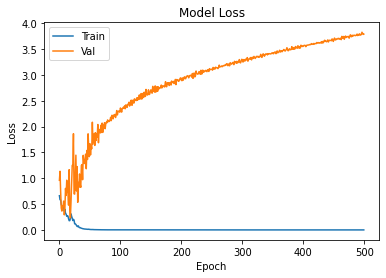

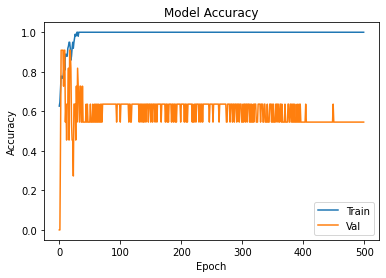

In [ ]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Summarize this model's results. Consider the following when answering:

1) How did this model compare to previous models? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

4) Adam is a powerful optimizer, and may quickly converge to an a minima. Did this happen with this model?

In [ ]:
print("max val accuracy", max(hist.history['val_accuracy']))
print("min val loss", min(hist.history['val_loss']))
print("\n\n")
print("final val accuracy", hist.history['val_accuracy'][-1])
print("final val loss", hist.history['val_loss'][-1])
print("\n\n")
print("final train accuracy", hist.history['accuracy'][-1])
print("final train loss", hist.history['loss'][-1])

max val accuracy 0.9090909361839294
min val loss 0.2348223179578781



final val accuracy 0.5454545617103577
final val loss 3.791013240814209



final train accuracy 1.0
final train loss 8.306473318953067e-06


### Answer: 
1) This model is much better than the previos models, but training it for 500 epochs increases loss in the validation data while mainitaing low loss value on training data. Causing the model to overfit. 

2) This model outperformed previos models as the:

max validation accuracy = 0.9090909361839294 

minimum validaiton loss = 0.2348223179578781

However, trainng it for too many epochs reduces the accuracy

3) This model overfits like the previos models as we are training the model for too many epochs. Hovewer, if we look at epochs around 26 we can see loss for both validation and test is around the same and model is not overfitting. And the loss is least for both training and validation data.

final val accuracy = 0.5454545617103577

final val loss = 3.791013240814209

4) Yes Adam quickly converged to an optimiser around 26 epochs, this shows Adam optimiser can converge to minima quickly. However, using an Adam optimser for too many epochs causes the model to overfit.
